# Introduction: Modeling

The last step in the machine learning pipeline is also where the value is derived. After we have developed the labels, each with its own cutoff time, we need to train a model to map from the features to predict the label. 

In this notebook, we will use the feature matrices and label times to train and test a machine learning model. We will work through a single prediction problem, predicting on the first of each month which customers will churn during the month with churn defined as no active membership for more than 31 days, a lead time of 1 month, and a prediction window of 1 month.

The general process of modeling is shown below:

![](../images/modeling_process.png)

## Approach

Our basic machine learning approach is:

1. Prepare data for machine learning
    * Fill in missing values with median imputation
    * Encoding of categorical values
2. Split data into training and hold out testing based on time 
3. Evaluate a baseline logistic regression model
    * Also try a naive baseline for comparison
4. Try a non-linear more capable classifier, the Random Forest 
    * Use mostly default hyperparameters
    * Evaluate on hold-out testing data
5. Inspect predictions to determine if business need has been met
    * Precision recall curve used to tune threshold
    * Confusion matrix to assess predictions
    * Determine business value
6. Optimizer model automatically using an auto-ml library
    * Using TPOT although many options exist
    
The final outcome is an optimized model that solves the business problem of predicting customer churn with given parameters. The model can be deployed - used to make predictions on new data

In [1]:
import os

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

CWD = os.getcwd()
PARTITION_DIR = f'{CWD}/data/partitions/'

In [2]:
p7_fm = pd.read_csv(f'{PARTITION_DIR}/p7/MS-31_feature_matrix.csv')
p7_fm.head()

,msno,time,city,bd,gender,registered_via,AVG_TIME_BETWEEN(transactions.transaction_date),COUNT(transactions),LAST(transactions.actual_amount_paid),LAST(transactions.daily_price),...,DAY(LAST(transactions.transaction_date)),IS_WEEKEND(LAST(logs.date)),IS_WEEKEND(LAST(transactions.membership_expire_date)),IS_WEEKEND(LAST(transactions.transaction_date)),MONTH(LAST(logs.date)),MONTH(LAST(transactions.membership_expire_date)),MONTH(LAST(transactions.transaction_date)),label,days_to_churn,churn_date
0,+0xzW79gt3V4AP3Y1lMKAYfHtlZWJ5WUempHeYOqLnw=,2015-07-01,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,+0xzW79gt3V4AP3Y1lMKAYfHtlZWJ5WUempHeYOqLnw=,2015-08-01,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,+1pSZrXcWvWf7GNJqXCaPQEx6NNjQ1VlyAgXEszTIRs=,2016-08-01,1.0,0.0,NaN,4.0,NaN,0,NaN,NaN,...,NaN,False,False,False,5.0,NaN,NaN,0.0,66.0,NaN
3,+1pSZrXcWvWf7GNJqXCaPQEx6NNjQ1VlyAgXEszTIRs=,2016-09-01,1.0,0.0,NaN,4.0,NaN,1,0.0,0.0,...,30.0,False,True,False,5.0,9.0,8.0,1.0,35.0,2016-10-06
4,+1pSZrXcWvWf7GNJqXCaPQEx6NNjQ1VlyAgXEszTIRs=,2016-10-01,1.0,0.0,NaN,4.0,NaN,1,0.0,0.0,...,30.0,False,True,False,5.0,9.0,8.0,0.0,5.0,NaN


### Retrieve Data

Normally for a problem of this size, all of the data would be stored in AWS S3, but for this example we have stored the data locally. We'll retrieve 20 partitions of feature matrices created in previous notebooks. For this problem, we'll use a lead offset of 1 month meaning that our predictions are made one month in advance. Adjsting this value significantly affects the performance because it is harder for the model to learn meaningful relationships farther out from the end of the features (which are determined by the cutoff time).

In [3]:
def retrieve_data(partition_num, label_type='MS-31'):
    """Retrieve features and labels and merge. Lead periods is the number of offsets"""

    # Read in features and labels
    fm = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory=False).\
        drop(columns=['label', 'days_to_churn', 'churn_date'])
    labels = pd.read_csv(
        f'{PARTITION_DIR}/p{partition_num}/{label_type}_labels.csv', low_memory=False)

    # Merge together features and labels
    feature_matrix = fm.merge(labels, on=[
                              'msno', 'time'], how='inner').sort_values(['msno', 'time'])

    return feature_matrix

In [4]:
fm = retrieve_data(5)
fm.head()

,msno,time,city,bd,gender,registered_via,AVG_TIME_BETWEEN(transactions.transaction_date),COUNT(transactions),LAST(transactions.actual_amount_paid),LAST(transactions.daily_price),...,DAY(LAST(transactions.transaction_date)),IS_WEEKEND(LAST(logs.date)),IS_WEEKEND(LAST(transactions.membership_expire_date)),IS_WEEKEND(LAST(transactions.transaction_date)),MONTH(LAST(logs.date)),MONTH(LAST(transactions.membership_expire_date)),MONTH(LAST(transactions.transaction_date)),label,days_to_churn,churn_date
0,+0kEcWM5x7HtJeNh997Sb8I02Gkw3qwq/fkpA4ZMU34=,2015-01-01,1.0,0.0,NaN,3.0,NaN,0,NaN,NaN,...,NaN,False,False,False,1.0,NaN,NaN,0.0,193.0,NaN
1,+0kEcWM5x7HtJeNh997Sb8I02Gkw3qwq/fkpA4ZMU34=,2015-02-01,1.0,0.0,NaN,3.0,NaN,1,149.0,4.966667,...,18.0,True,False,True,1.0,2.0,1.0,0.0,162.0,NaN
2,+0kEcWM5x7HtJeNh997Sb8I02Gkw3qwq/fkpA4ZMU34=,2015-03-01,1.0,0.0,NaN,3.0,3024000.0,2,149.0,4.966667,...,22.0,True,False,True,3.0,3.0,2.0,0.0,134.0,NaN
3,+0kEcWM5x7HtJeNh997Sb8I02Gkw3qwq/fkpA4ZMU34=,2015-04-01,1.0,0.0,NaN,3.0,2980800.0,3,149.0,4.966667,...,28.0,False,False,True,4.0,4.0,3.0,0.0,103.0,NaN
4,+0kEcWM5x7HtJeNh997Sb8I02Gkw3qwq/fkpA4ZMU34=,2015-05-01,1.0,0.0,NaN,3.0,2980800.0,3,149.0,4.966667,...,28.0,False,False,True,4.0,4.0,3.0,0.0,73.0,NaN


The next cell retrieves a number of feature matrices for training and for testing.

In [5]:
# Set number of train and testing feature matrices
fms_to_get = 20

# Retrieve feature matrices from disk
fms = []
for i, r in enumerate(range(fms_to_get)):
    fm = retrieve_data(r)
    print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
    fms.append(fm)

# Join together and drop rows with unknown label
feature_matrix = pd.concat(fms)
feature_matrix = feature_matrix[~feature_matrix['label'].isna()].sort_values([
    'msno', 'time'])

# Drop rows with no previous transactions
feature_matrix = feature_matrix[~feature_matrix['TIME_SINCE_LAST(transactions.transaction_date)'].isna(
)]

feature_matrix.shape

(312333, 321)

The cell below converts the boolean types to integers for use in a machine learning model. Most of the boolean indicate whether or not all the values for customer were True (`All` primitive) or if the date was a weekend (`IsWeekend` primitive).

In [6]:
feature_matrix = feature_matrix.replace({False: 0, True: 1})

In [7]:
feature_matrix_original = feature_matrix.copy()
feature_matrix.drop(columns=[c for c in ['churn', 'days_to_next_churn',
                                         'churn_date'] if c in feature_matrix],
                    inplace=True)

bool_cols = [c for c in feature_matrix if 'ALL' in c or (
    'WEEKEND' in c and 'PERCENT_TRUE' not in c)]

for c in bool_cols:
    feature_matrix[c] = feature_matrix[c].astype(float)
feature_matrix[bool_cols].head()

,IS_WEEKEND(registration_init_time),LAST(transactions.IS_WEEKEND(membership_expire_date)),LAST(transactions.IS_WEEKEND(transaction_date)),LAST(logs.IS_WEEKEND(date)),IS_WEEKEND(LAST(logs.date)),IS_WEEKEND(LAST(transactions.membership_expire_date)),IS_WEEKEND(LAST(transactions.transaction_date))
1,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
feature_matrix = feature_matrix.drop_duplicates(subset = ['msno', 'time'])

## Data Cleaning

We'll do a few basic data cleaning steps:

* Remove columns with many missing values
* Remove columns with a single unique value
* Remove highly correlated - colinear - columns

#### Missing Values

We'll drop any columns with more than 90% missing values.

In [9]:
missing_pct = feature_matrix.isnull().sum() / len(feature_matrix)
to_drop = list((missing_pct[missing_pct > 0.9]).index)
to_drop = [x for x in to_drop if x != 'days_to_churn']
to_drop

[]

In [10]:
feature_matrix.drop(columns=to_drop, inplace=True)
feature_matrix.shape

(312333, 320)

#### One Unique Value

Columns with only a single unique value contain no information and hence can be dropped.

In [11]:
one_unique = feature_matrix.apply(lambda x: x.nunique() == 1, axis=0)
to_drop = list(one_unique[one_unique == True].index)
to_drop

[]

In [12]:
feature_matrix.drop(columns=to_drop, inplace=True)
feature_matrix.shape

(312333, 320)

#### Highly Correlated (collinear) Columns

Collinear columns can slow down training, lead to less interpretable models, and decrease generalization performance. Therefore, it's generally a good idea to remove one of each pair of highly correlated columns for machine learning. The following code identifies columns that exceed an absolute magnitude correlation of 0.95.

In [13]:
threshold = 0.95

# Calculate correlations
corr_matrix = feature_matrix.corr().abs()

# Subset to the upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Identify names of columns with correlation above threshold
to_drop = [column for column in upper.columns if any(
    upper[column] >= threshold)]

In [14]:
print(
    f'There are {len(to_drop)} columns to drop with correlation > {threshold}')

There are 168 columns to drop with correlation > 0.95


In [15]:
feature_matrix.drop(columns=to_drop, inplace=True)
feature_matrix.shape

(312333, 152)

These data cleaning operations should increase the generalization performance of our model and make it more interpretable. A few simple operations can greatly improve a machine learning model and often are more effective than model optimization.

# Separate into Training and Testing Set

We'll separate into a training and testing set based on the date. We'll use 25% of the data in the testing and 75% in the training. Separating training and testing by the date is important in time sensitive problems because it prevents data leakage and gives a better estimate of the generalization performance of the model. On real data, our model will have to make forecasts of the future, and we can try to recreate that situation by using a hold-out set from later in time than the training data.

In [16]:
feature_matrix['time'] = pd.to_datetime(feature_matrix['time'])
feature_matrix['time'].describe()

count                  312333
unique                     25
top       2016-10-01 00:00:00
freq                    16085
first     2015-01-01 00:00:00
last      2017-01-01 00:00:00
Name: time, dtype: object

The cell below splits the data based on the time. We'll try to use about 30% of the data for testing and the rest for training.

In [17]:
split_date = pd.datetime(2016, 8, 1)


train = feature_matrix.loc[feature_matrix['time'] < split_date].copy()
test = feature_matrix.loc[feature_matrix['time'] >= split_date].copy()

train.sort_values(['time'], inplace=True)
test.sort_values(['time'], inplace=True)
train.shape, test.shape

((219516, 152), (92817, 152))

In [18]:
len(train) / len(feature_matrix)

0.7028267906369163

# Feature Preparation

The next blocks of code get the features ready for machine learning.


### Encoding Categoricals

First we need to one hot encode the features. After doing this, we align the training and testing dataframes so they have the same columns.

In [19]:
train = pd.get_dummies(train.drop(columns=['time', 'msno']))
test = pd.get_dummies(test.drop(columns=['time', 'msno']))

train, test = train.align(test, join='inner', axis=1)
train.shape, test.shape

((219516, 151), (92817, 151))

### Extract the Labels

Now we can extract the labels. There are two different problems: one is a binary classification of whether or not the customer will churn during the month. The other is a regression: how many days are there until the next churn.

In [20]:
y, test_y = np.array(train.pop('label')), np.array(test.pop('label'))

y_reg, test_y_reg = np.array(train.pop('days_to_churn')), np.array(
    test.pop('days_to_churn'))

Text(0, 0.5, 'Count')

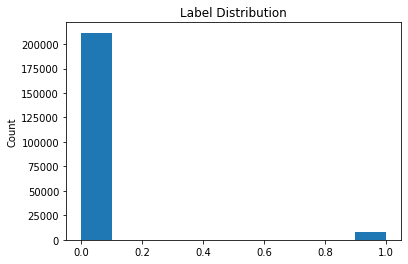

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y)
plt.title('Label Distribution')
plt.ylabel('Count')

### Fill in Missing Values

We can fill in missing values using the median of the column. As an important note, the missing test values are filled in with the median of the corresponding training feature.

In [22]:
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(train.median())

In [23]:
np.any(train.isnull()), np.any(np.isinf(train))

(False, False)

In [24]:
test = test.replace([np.inf, -np.inf], np.nan)
test = test.fillna(train.median())

In [25]:
np.any(test.isnull()), np.any(np.isinf(test))

(False, False)

Now that there are no missing values and all of the values are numeric, our data is ready for machine learning. However, before we do machine learning, we need to figure out what a naive baseline would score.

# Naive Baseline

For a naive baseline, we can randomly guess that a customer has churned with the same frequence of the churns in the training data. We'll assess the predictions using a number of different metrics.

## Metrics

For an imbalanced classification problem, there are a number of metrics to consider:

* Receiver Operating Characteristic Area Under the Curve (ROC AUC): a measure between 0 and 1 comparing the performance of the classifier when predicting probabilities across a range of thresholds.
* Precision Score: number of true positives divided by the total number of positives predicted
* Recall Score: number of true positives divided by the total number of actual positives in the data
* F1 Score: Harmonic mean of precision and recall

The exact metric used and the threshold that our model needs to reach depends on the business need. We can tune the model to some extent to optimize for different metrics.

In [26]:
np.random.seed(50)
naive_guess = np.random.binomial(1, p=np.mean(y), size=len(test_y))
naive_guess[:10], naive_guess.sum()

(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), 3216)

In [27]:
from sklearn.metrics import (roc_auc_score, precision_score,
                             recall_score, f1_score)

print(f'Naive Baseline\n')
roc = roc_auc_score(test_y, np.repeat(np.mean(y), len(test_y)))
print(f'ROC AUC: {round(roc, 4)}')

for metric in [precision_score, recall_score, f1_score]:
    print(f'{metric.__name__}: {round(metric(test_y, naive_guess), 4)}')

Naive Baseline

ROC AUC: 0.5
precision_score: 0.0106
recall_score: 0.0354
f1_score: 0.0163


We can see that these metrics are very poor! A naive approach clearly does not provide much value.

In [28]:
print(
    f'The percentage of churns is {100 * round(np.mean(y), 2)}% in the training data.')

The percentage of churns is 4.0% in the training data.


## More Complex Model

For a potentially better machine learning model, we can move to the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

We'll use most of the default hyperparameters but alter a few to prevent overfitting. We can also set `class_weight = 'balanced'` to try and offset the impact of such an imbalanced classification problem.

In [29]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


def evaluate(model, train, y, test, test_y):
    """Evaluate a machine learning model on four metrics:
       ROC AUC, precision score, recall score, and f1 score.

       Returns the model and the predictions."""

    model.fit(train, y)

    # Predict probabilities and labels
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    # Calculate ROC AUC
    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    # Iterate through metrics
    for metric in [precision_score, recall_score, f1_score]:
        # Use .__name__ attribute to list metric
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds

In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf=50,
                               n_jobs=-1, class_weight='balanced',
                               random_state=50)

model, preds = evaluate(model, train, y, test, test_y)

RandomForestClassifier

ROC AUC: 0.9245
precision_score: 0.1246
recall_score: 0.6219
f1_score: 0.2075


The random forest performance is much better than just guessing! This should give us confidence that we can solve this problem using machine learning.

# Model Validation

We need to inspect the model results to determine if it meets our business needs. This includes looking at the performance as well as the feature importances. We want to make sure that our model performs well, but also try and understand _why_ it performs well. 

## Precision Recall Curve

One of the best methods for tuning a model for a business need is through the precision recall curve. This shows the precision-recall tradeoff for different thresholds. Depending on the business requirement, we can change the threshold for classifying a positive example to alter the balance of true positives, false positives, false negatives, and true negatives. There will always be a tradeoff between precision and recall, but we can try to find the right balance by visually and quantitatively assessing the model.

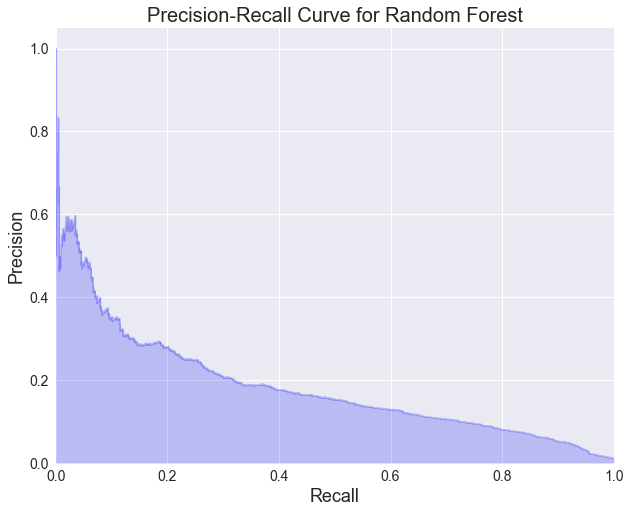

In [31]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')


def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 8))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=18)
    plt.ylabel('Precision', size=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=20)
    plt.xticks(size=14)
    plt.yticks(size=14)

    if threshold_selected:
        p = precision(np.where(threshold == threshold_selected)[0])
        r = recall(np.where(threshold == threshold_selected)[0])
        plt.scatter(r, p, marker='*', size=200)
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr


probs = model.predict_proba(test)[:, 1]
pr_data = plot_precision_recall(
    test_y, probs, title='Precision-Recall Curve for Random Forest')

We can query the dataframe to find the threshold required for a given precision or recall. For example, to find the threshold for a precision of 25%, we use the following code:

In [32]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

,precision,recall,threshold
88044,0.250000,0.242708,0.732123
88045,0.250269,0.242708,0.732163
88048,0.250000,0.241667,0.732227
88050,0.250540,0.241667,0.732349
88049,0.250270,0.241667,0.732286


We can see that if we want a precision of 25%, then our recall will be 25%. This means we'll miss over 75% of the true churns in the data.

### Adjusting for the Business Requirement

Let's say we are required to have a recall of 75% in our model. This means our model finds 75% of the true churns in the data. We'll work through the rest of this notebook under this assumption. To find the threshold, we use:

In [33]:
recall_attained = 0.75
recall_above = pr_data.loc[pr_data['recall'] >= recall_attained].copy()
recall_above.sort_values('precision', ascending=False, inplace=True)
recall_above.head()

,precision,recall,threshold
81447,0.094712,0.75,0.407157
81446,0.094699,0.75,0.407048
81445,0.094687,0.75,0.407047
81444,0.094675,0.75,0.407009
81443,0.094662,0.75,0.407004


In [34]:
precision_attained = recall_above.iloc[0, 0]
threshold_required = recall_above.iloc[0, -1]

print(
    f'At a threshold of {round(threshold_required, 4)} the recall is {100 * recall_attained:.2f}% and the precision is {round(100 * precision_attained, 4)}%')

At a threshold of 0.4072 the recall is 75.00% and the precision is 9.4712%


This means that in order to identify 75% of the actual churns, we'll have to accept that only 9.5% of the predicted positives are actually positive churns. 

In [35]:
def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 10))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=24)
    plt.ylabel('Precision', size=24)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

    if threshold_selected:
        p = precision[np.where(threshold == threshold_selected)[0]]
        r = recall[np.where(threshold == threshold_selected)[0]]
        plt.scatter(r, p, marker='*', s=600, c='r')
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')
        plt.text(r - 0.1, p + 0.15,
                 s=f'Threshold: {round(threshold_selected, 2)}', size=20, fontdict={'weight': 1000})
        plt.text(r - 0.2, p + 0.075,
                 s=f'Precision: {round(100 * p[0], 2)}% Recall: {round(100 * r[0], 2)}%', size=20,
                 fontdict={'weight': 1000})

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr

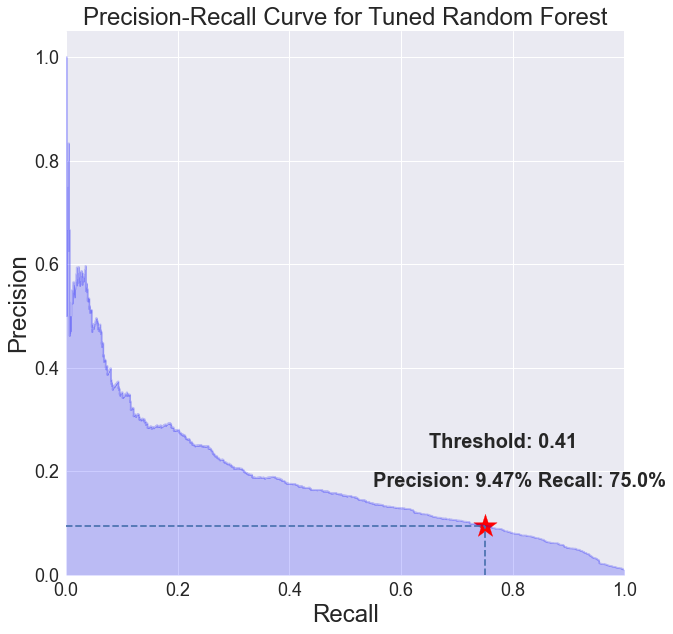

In [36]:
pr_data = plot_precision_recall(test_y, probs, title='Precision-Recall Curve for Tuned Random Forest',
                                threshold_selected=threshold_required)

## Confusion Matrix

A confusion matrix is often a useful way to visualize predictions. This shows the true values along the top row and the predicted values along the bottom row. Looking at the different cells, we can see where the model performed well and where it did not do so well.

We'll use the threshold identified above to construct the confusion matrix.

In [37]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.style.use('bmh')
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size=20)
    plt.grid(None)
    plt.ylabel('True label', size=22)
    plt.xlabel('Predicted label', size=22)
    plt.tight_layout()

Confusion matrix, without normalization
[[84975  6882]
 [  240   720]]


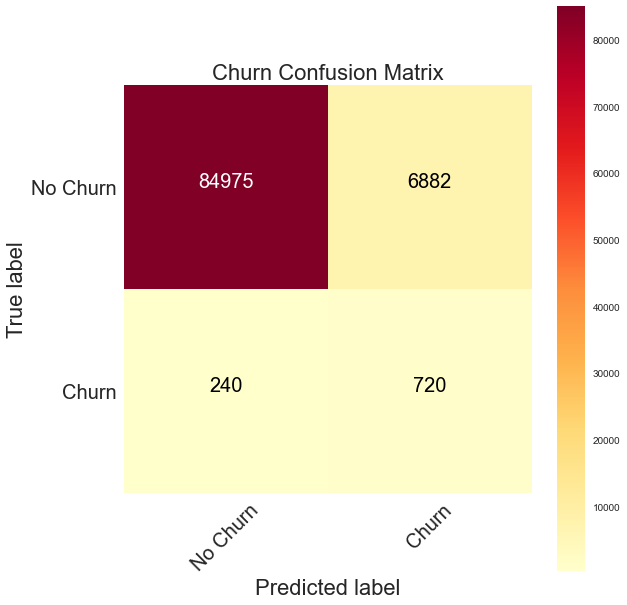

In [38]:
# Make predictions where probability is above threshold
preds = np.zeros(len(test_y))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

If we satisfy our business requirement, this is the best prediction of what our performance would be on new data. The model is able to identiy 75% of churned customers compared to a baseline of around 3%. The precision has increased from the baseline 1% to 9%, a relative increase of over 900%.

### Feature Importances

As one method for trying to understand how the model makes decisions, we can look at the most important features. The absolute value of the importances is not as useful as is the relative ranking of the features which is determined by how well the feature separates the classes when building the decision trees in the random forest.

In [39]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=train.columns).\
    sort_values('importance', ascending=False)
fi.head(10)

,importance
TIME_SINCE_LAST(transactions.transaction_date),0.127209
LAST(transactions.payment_method_id),0.047209
AVG_TIME_BETWEEN(transactions.transaction_date),0.043560
LAST(transactions.DAY(transaction_date)),0.035853
SUM(transactions.actual_amount_paid WHERE is_auto_renew = True),0.034439
LAST(transactions.MONTH(transaction_date)),0.027998
SUM(transactions.CUM_SUM(actual_amount_paid) WHERE is_auto_renew = True),0.024065
PERCENT_TRUE(transactions.IS_WEEKEND(membership_expire_date) WHERE is_auto_renew = True),0.023547
NUM_UNIQUE(transactions.DAY(transaction_date)),0.022384
LAST(transactions.DAY(membership_expire_date)),0.019631


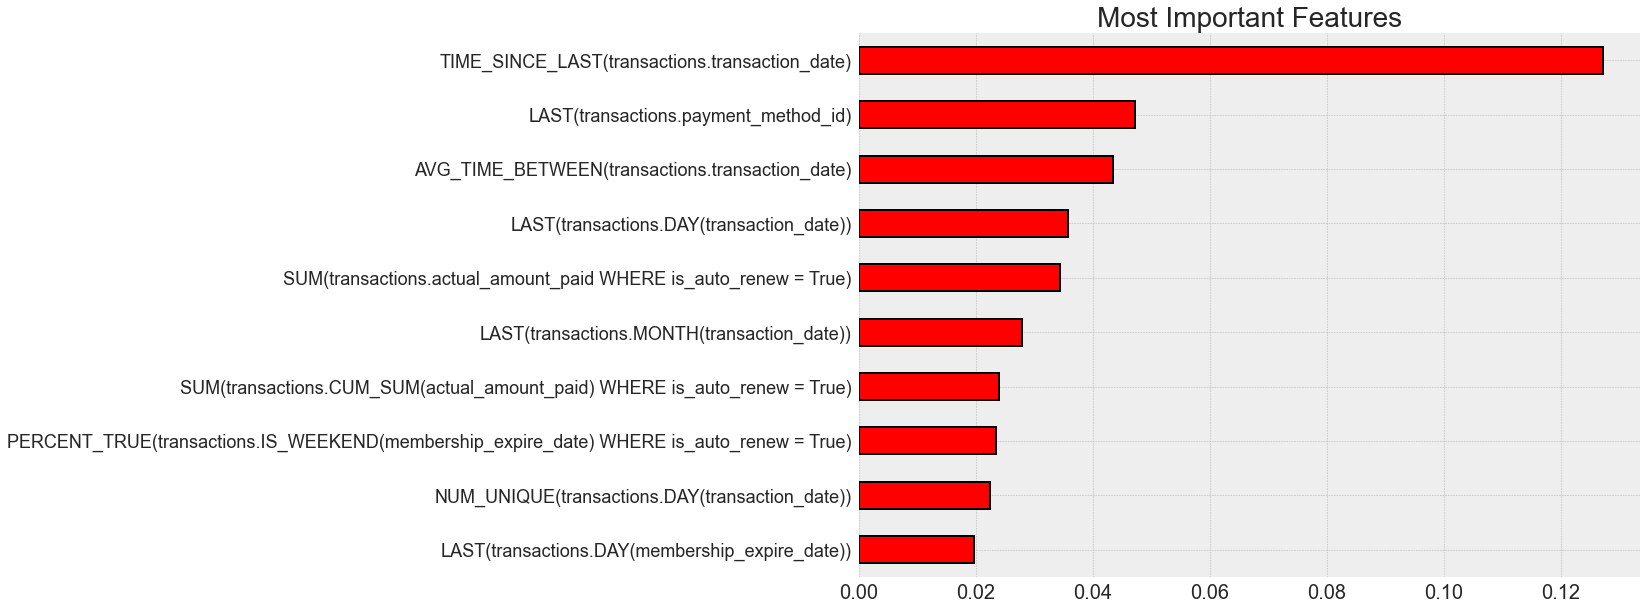

In [40]:
fi.iloc[:10]['importance'].plot.barh(color='r', edgecolor='k',
                                     figsize=(14, 10), linewidth=2)
ax = plt.gca()
ax.invert_yaxis()
plt.xticks(size=20)
plt.yticks(size=18)
plt.title('Most Important Features', size=28);

# Make Predictions

Now we will use the trained model to make predictions on the hold-out testing set. We'll can make predictions in terms of probabilities and then threshold them to labels using our selected threshold.

In [41]:
new_probs = model.predict_proba(test)[:, 1]


oos_ids = list(feature_matrix.loc[feature_matrix['time'] >= split_date, 'msno'])
oos_cutoff_time = list(feature_matrix.loc[feature_matrix['time'] >= split_date, 'time'])

prediction_df = pd.DataFrame({'msno': oos_ids, 'time': oos_cutoff_time,
                              'probability': new_probs})
prediction_df['prediction'] = prediction_df['probability'] > threshold_required
prediction_df.sample(10)

,msno,time,probability,prediction
57527,byin6g4267N0G5O18fdOpvF2MIPRlZOd+QyeYVENh6Y=,2016-09-01,0.065201,False
5218,1THjjESCatYwRZAdx5erdLZoj9KCNNv2HBjMmTET7nQ=,2017-01-01,0.263145,False
77896,ptqi7NWmOHFZh9g+bxtvjglpovX4v8x5lbJvVa5Ia/I=,2016-08-01,0.024292,False
31542,JmrF6myL588zBGH3HkDqjNybyXwRmUaF/k8hSgAsndI=,2016-11-01,0.043056,False
81813,sRhLZKS2P1fKTVoJ3TDJeY05IK6w/xYNcQl8G63mKDw=,2016-09-01,0.077044,False
24509,EtKFhIZai5VQQDqLPrs8flsQzj0IbPiqH8YnslnLQxM=,2016-12-01,0.032892,False
56156,b1mjN+HHODZqtqGW6qml6lFUg/DkB+GvepKSGWt5vdY=,2016-09-01,0.293019,False
1913,/FGfUHjCKRSKhI7QFEnOe5ehF7MGGJyjDVUE58jDPhQ=,2016-09-01,0.031265,False
90565,yK1T7Rn3c86YerkuPeOvBozWlTuR/Q5sfFNfrLPlFFU=,2016-10-01,0.034706,False
47533,VKbul9NW2zYfXYKDR0mkHhVxDMDF8Vypl1M5NGzXO+U=,2016-08-01,0.152698,False


Text(0.5, 1.0, 'Distribution of Predicted Probabilities')

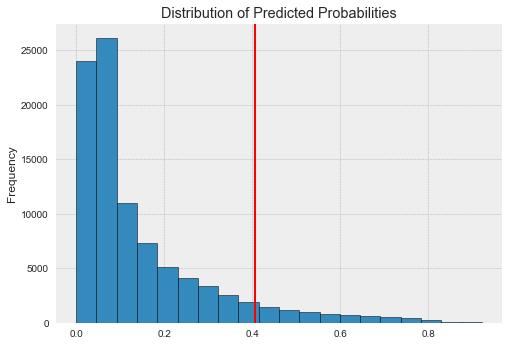

In [42]:
prediction_df['probability'].plot.hist(bins=20, edgecolor='k')
plt.axvline(x=threshold_required, color='r', linewidth=2)
plt.title('Distribution of Predicted Probabilities')

The model is fairly confident that most of the predictions are not churns. Moreover, there are a number of probabilities that are exactly the same as can be seen in the [empirical cumulative density function](https://en.wikipedia.org/wiki/Empirical_distribution_function). 

In [43]:
# Inspiration: https://campus.datacamp.com/courses/statistical-thinking-in-python-part-1/graphical-exploratory-data-analysis?ex=12
def ecdf(x):
    n = len(x)
    x = np.sort(x)
    y = np.arange(1, n + 1) / n
    return x, y

Text(0, 0.5, 'Percentile')

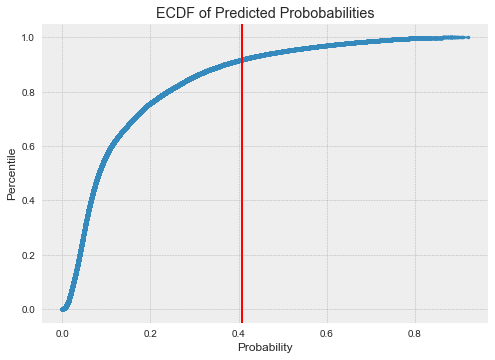

In [44]:
xs, ys = ecdf(prediction_df['probability'])
plt.plot(xs, ys, marker='.')
plt.title('ECDF of Predicted Probobabilities')
plt.axvline(x=threshold_required, color='r', linewidth=2)
plt.xlabel('Probability')
plt.ylabel('Percentile')

# Business Value Analysis

Using the metrics from the model, we can conduct an analysis of the business value of our solution. We'll use the precision and recall along with a few assumptions.

* Typical plan price = 150 (NTD)
* Reduced plan price = 130 (NTD)
* Recall = 75%
* Precision = 9.5%
* Conversion Rate = 75%

$$\text{Recall} = \frac{TP}{TP + FN}$$

$$\text{Precision} = \frac{TP}{TP + FP}$$

We can scale our analysis to the entire dataset since we only used a subset of it for modeling. We'll assume we are able to achieve the same performance on the entire dataset, which is reasonable because the accuracy of a model generally improves as the amount of data used increases.

In [45]:
plan_price = 150
r_plan_price = 130
recall = recall_attained
precision = precision_attained
conversion_rate = 0.75

# Find total number of members
n_members = pd.read_csv(f'{CWD}/data/members_v3.csv', usecols = ['msno']).shape[0]
monthly_revenue = n_members * plan_price
churn_rate = np.mean(feature_matrix['label'])

churns = int(churn_rate * n_members)
# Find the typical monthly revenue lost to churned customers
revenue_lost_churns = n_members * churn_rate * plan_price
print(f'Typical monthly revenue lost to {churns} churned customers = ${revenue_lost_churns:,.2f} (NTD).')
print(f'Typical total monthly revenue = ${monthly_revenue:,.2f}.')
print(f'Churns losses represent {100 * (revenue_lost_churns / monthly_revenue):.2f}% of monthly revenue.')

Typical monthly revenue lost to 191597 churned customers = $28,739,586.27 (NTD).
Typical total monthly revenue = $1,015,420,950.00.
Churns losses represent 2.83% of monthly revenue.


In [46]:
# Find stats for entire dataset
true_positives = int(churns * recall)
false_negatives = int(churns - true_positives)
false_positives = int((true_positives * (1 - precision)) / precision)

print(f'True positives: {true_positives}; False negatives: {false_negatives}; False positives: {false_positives}.')

True positives: 143697; False negatives: 47900; False positives: 1373503.


As a sanity check, we'll make sure the precision and recall metrics come out right.

In [47]:
(true_positives) / (true_positives + false_positives)

0.09471196941734775

In [48]:
(true_positives) / (true_positives + false_negatives)

0.7499960855336983

Things look right here.

In [49]:
revenue_lost_false_positives = false_positives * (plan_price - r_plan_price)
revenue_lost_false_negatives = false_negatives * plan_price
revenue_recouped_true_positives = conversion_rate * (true_positives * r_plan_price)

print(f'Cost from false positives = ${revenue_lost_false_positives:,.2f} (NTD); Cost from false negatives = ${revenue_lost_false_negatives:,.2f} (NTD)')
print(f'Revenue recouped from true positives = ${revenue_recouped_true_positives:,.2f} (NTD).')

Cost from false positives = $27,470,060.00 (NTD); Cost from false negatives = $7,185,000.00 (NTD)
Revenue recouped from true positives = $14,010,457.50 (NTD).


In [50]:
total_effect = revenue_lost_churns - (-revenue_recouped_true_positives + revenue_lost_false_positives + revenue_lost_false_negatives)
us_dollars = total_effect * 0.033
print(f'Total Effect of identifying churns ${total_effect:,.2f} (NTD) = ${us_dollars:,.2f} (USD).')
print(f'This represents {100 * (total_effect / revenue_lost_churns):.2f}% of the losses due to churns.')

Total Effect of identifying churns $8,094,983.77 (NTD) = $267,134.46 (USD).
This represents 28.17% of the losses due to churns.


Our model has successfully solved the business problem. This does require a number of assumptions, but with additional refinement, our model could probably deliver even greater value.

# Conclusions

Our final tuned model was able to achieve  a significant increase over the naive baseline model. We can now use this model to predict customers at risk for churning in the future. An analysis of the business payback also showed that the final model delivered significant value. The predictions would then be handed off to the customer engagement team to hopefully reduce the number of churns.

The framework for solving this problem - and for solving any problem with machine learning - was:

1. Prediction Engineering: define the business objective, translate into a machine learning task, and create a set of labeled historical examples with cutoff time from the data.
2. Feature Engineering: use the label times to automatically build hundreds of relevant and valid features for each label.
3. Modeling: use a machine learning algorithm implemented in common Python libraries to train a model to predit the labels from the features. Validate and tune model for the business need and then make predictions on new data.

![](../images/Framework.png)

This approach solves a number of problems: it standardizes the traditionally ad-hoc process of solving a problem with machine learning and it is general so that nearly the same code can be used for multiple prediction problems on the same dataset. The benefits of machine learning have been limited to a few companies both because of the lack of a shared language for expressing and solving problems, and because each solution requires custom code and must be completely rebuilt for a different prediction problem. By codifying the processes needed to solve problems with machine learning, we aim to make it easier for companies to use this transformational technology. 

Furthermore, the framework lets data scientists fill in the details with existing tools allowing for rapid development and deployment of model pipelines. The achievements of machine learning are already impressive, but with a scaffolding in place the benefits can be extended to a broader population.
